In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
import os
import tarfile
from collections import OrderedDict
import pandas as pd
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
from tqdm import tqdm # For progress bars

# Scikit-learn (for evaluation)
from sklearn.metrics import accuracy_score, top_k_accuracy_score, confusion_matrix

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [10]:
# Set CUDA to run synchronously for better error messages
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.5.1
CUDA available: True


In [11]:
# --- 1. Define Paths ---
DATASET_PATH = "." # We are in the 'aml-project' directory
TRAIN_LIST_FILE = os.path.join(DATASET_PATH, "list/train.txt")
TEST_LIST_FILE = os.path.join(DATASET_PATH, "list/test.txt")
TEST_TRUTH_FILE = os.path.join(DATASET_PATH, "list/groundtruth.txt")
WITH_PAIRS_FILE = os.path.join(DATASET_PATH, "list/class_with_pairs.txt")
WITHOUT_PAIRS_FILE = os.path.join(DATASET_PATH, "list/class_without_pairs.txt")
TRAIN_IMG_DIR = DATASET_PATH
TEST_IMG_DIR = DATASET_PATH

# Path to save our best model
BEST_MODEL_PATH = "best_finetuned_model.pth"

# --- 2. Define Hyperparameters ---
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_EPOCHS = 20        # Start with 20, you can increase this
BATCH_SIZE = 32        # Adjust based on your GPU memory
LEARNING_RATE = 0.001
NUM_CLASSES = 100
VAL_SPLIT = 0.2          # Use 20% of training data for validation

print(f"Using device: {DEVICE}")

Using device: cuda


In [12]:
print("Building label map...")
# Load all labels from both training and test ground truth
train_labels_df = pd.read_csv(TRAIN_LIST_FILE, sep=' ', header=None)[1]
test_labels_df = pd.read_csv(TEST_TRUTH_FILE, sep=' ', header=None)[1]

# Combine them and get all unique, sorted species IDs
all_unique_species_ids = sorted(pd.concat([train_labels_df, test_labels_df]).unique())

# Create the map: {species_id: index_from_0_to_99, ...}
label_map = {species_id: i for i, species_id in enumerate(all_unique_species_ids)}
num_mapped_classes = len(label_map)

print(f"Label map created. Total unique classes found: {num_mapped_classes}")
print(f"Example mapping: ID {all_unique_species_ids[0]} -> Index {label_map[all_unique_species_ids[0]]}")

Building label map...
Label map created. Total unique classes found: 100
Example mapping: ID 12254 -> Index 0


In [13]:
# --- 1. Define Augmentations ---

# Heavy augmentation for HERBARIUM images (the "source" domain)
train_herbarium_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # Stronger
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45), # Stronger
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Light augmentation for PHOTO images (the "target" domain)
train_photo_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# NO augmentation for Validation or Test data
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# --- 2. Modify PlantDataset ---
# Applies the correct transform based on the image path
class PlantDataset(Dataset):
    def __init__(self, txt_file, img_dir, label_map,
                 herbarium_transform=None, photo_transform=None, 
                 default_transform=None, is_test=False):
        self.is_test = is_test
        self.img_data = pd.read_csv(txt_file, sep=' ', header=None)
        self.img_dir = img_dir
        self.label_map = label_map
        self.herbarium_transform = herbarium_transform
        self.photo_transform = photo_transform
        self.default_transform = default_transform

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, idx):
        img_name = self.img_data.iloc[idx, 0]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        transform = self.default_transform
        if self.herbarium_transform and 'herbarium/' in img_name:
            transform = self.herbarium_transform
        elif self.photo_transform and 'photo/' in img_name:
            transform = self.photo_transform

        if transform:
            image = transform(image)
        
        if self.is_test:
            return image
        else:
            species_id = int(self.img_data.iloc[idx, 1])
            label = self.label_map[species_id]
            return image, label

print("Dataset class and transforms defined.")

Dataset class and transforms defined.


In [14]:
# --- 1. Create Datasets and Split ---
full_train_dataset = PlantDataset(txt_file=TRAIN_LIST_FILE,
                                  img_dir=TRAIN_IMG_DIR,
                                  label_map=label_map,
                                  herbarium_transform=train_herbarium_transform,
                                  photo_transform=train_photo_transform)

val_dataset_for_split = PlantDataset(txt_file=TRAIN_LIST_FILE,
                                     img_dir=TRAIN_IMG_DIR,
                                     label_map=label_map,
                                     default_transform=val_test_transform)

val_size = int(len(full_train_dataset) * VAL_SPLIT)
train_size = len(full_train_dataset) - val_size
train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])
val_dataset.dataset = val_dataset_for_split # Ensures validation uses no augmentations

test_dataset = PlantDataset(txt_file=TEST_LIST_FILE,
                            img_dir=TEST_IMG_DIR,
                            label_map=label_map,
                            default_transform=val_test_transform,
                            is_test=True)

print(f"Split into: {len(train_dataset)} training, {len(val_dataset)} validation")
print(f"Test data: {len(test_dataset)} samples")

# --- 2. Handle Class Imbalance ---
print("\nCalculating class weights for imbalance...")
all_train_labels = pd.read_csv(TRAIN_LIST_FILE, sep=' ', header=None)[1].map(label_map)
class_counts_series = all_train_labels.value_counts()

full_class_index = np.arange(NUM_CLASSES)
class_counts = class_counts_series.reindex(full_class_index, fill_value=0).sort_index()
counts_plus_one = torch.tensor(class_counts.values, dtype=torch.float) + 1.0 # Add 1 to avoid / 0
class_weights = 1.0 / counts_plus_one
class_weights = class_weights / class_weights.sum() * NUM_CLASSES # Normalize
class_weights = class_weights.to(DEVICE)
print(f"Class weights tensor created with {len(class_weights)} entries.")

# --- 3. Create DataLoaders ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"DataLoaders created.")

# --- 4. Load and map ground truth test labels ---
original_test_labels = pd.read_csv(TEST_TRUTH_FILE, sep=' ', header=None).iloc[:, 1].values
y_test = np.array([label_map[label] for label in original_test_labels])
print(f"y_test (ground truth) labels loaded and mapped to [0-99].")

Split into: 3796 training, 948 validation
Test data: 207 samples

Calculating class weights for imbalance...
Class weights tensor created with 100 entries.
DataLoaders created.
y_test (ground truth) labels loaded and mapped to [0-99].


In [15]:
import argparse
print("Downloading model files...")
model_dir = kagglehub.model_download("juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default")
WEIGHTS_FILE = os.path.join(model_dir, 'model_best.pth.tar')
print(f"Weights file path: {WEIGHTS_FILE}")

# --- 1. Load the CORRECT Model Architecture ---
print("Loading DINOv2 ViT-Base (vitb14_reg) architecture...")
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
print("Architecture loaded.")

# --- 2. Load Your Downloaded Kaggle Checkpoint ---
print(f"Loading weights from checkpoint: {WEIGHTS_FILE}")
torch.serialization.add_safe_globals([argparse.Namespace]) # Allow loading 'argparse'
checkpoint = torch.load(WEIGHTS_FILE, map_location='cpu', weights_only=True)

# --- 3. Extract and Clean the 'state_dict' ---
if 'state_dict' in checkpoint:
    state_dict = checkpoint['state_dict']
    print("Found 'state_dict' key in checkpoint.")
else:
    raise KeyError("Checkpoint does not contain 'state_dict' key.")
    
print("Cleaning checkpoint state_dict...")
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace('module.', '')
    if name == 'reg_token': name = 'register_tokens'
    if 'head.' in name: continue # Skip old head
    if name == 'pos_embed':
        model_pos_embed = model.state_dict()['pos_embed']
        if v.shape != model_pos_embed.shape:
            zeros_to_add = torch.zeros(1, 1, v.shape[2])
            v = torch.cat((v, zeros_to_add), dim=1)
    new_state_dict[name] = v

# --- 4. Load Cleaned Weights into Model ---
model.load_state_dict(new_state_dict, strict=False) # strict=False ignores the missing 'mask_token'
print("Successfully loaded Kaggle weights into model architecture.")

# --- 5. Freeze the Backbone ---
print("Freezing backbone parameters...")
for param in model.parameters():
    param.requires_grad = False

# --- 6. Replace the Classifier Head ---
# This NEW head will have requires_grad=True by default.
model.head = nn.Linear(768, NUM_CLASSES)
print(f"Replaced head with new nn.Linear(768, {NUM_CLASSES}).")

# --- 7. Move to GPU ---
model = model.to(DEVICE)
print(f"Model moved to {DEVICE}.")

Weights file path: /home/wongxuanyong/.cache/kagglehub/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default/3/model_best.pth.tar
Loading DINOv2 ViT-Base (vitb14_reg) architecture...


Using cache found in /home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main


Architecture loaded.
Loading weights from checkpoint: /home/wongxuanyong/.cache/kagglehub/models/juliostat/dinov2_patch14_reg4_onlyclassifier_then_all/pyTorch/default/3/model_best.pth.tar
Found 'state_dict' key in checkpoint.
Cleaning checkpoint state_dict...
Successfully loaded Kaggle weights into model architecture.
Freezing backbone parameters...
Replaced head with new nn.Linear(768, 100).
Model moved to cuda.


In [16]:
# --- 1. Define Loss Function and Optimizer ---
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.AdamW(model.head.parameters(), lr=LEARNING_RATE) # Only train the new head

# --- 2. Training Loop ---
best_val_acc = 0.0
history_train_loss = []
history_train_acc = []
history_val_loss = []
history_val_acc = []

for epoch in range(NUM_EPOCHS):
    print(f"\n--- Epoch {epoch+1}/{NUM_EPOCHS} ---")
    
    # --- Training Phase ---
    model.train() 
    train_loss = 0.0
    train_correct = 0
    
    for images, labels in tqdm(train_loader, desc="Training"):
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_correct += torch.sum(preds == labels.data)
        
    train_acc = train_correct.double() / len(train_dataset)
    train_loss = train_loss / len(train_dataset)
    print(f"Training Loss: {train_loss:.4f} | Training Acc: {train_acc*100:.2f}%")

    # --- Validation Phase ---
    model.eval() 
    val_loss = 0.0
    val_correct = 0
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validating"):
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += torch.sum(preds == labels.data)

    val_acc = val_correct.double() / len(val_dataset)
    val_loss = val_loss / len(val_dataset)
    print(f"Validation Loss: {val_loss:.4f} | Validation Acc: {val_acc*100:.2f}%")
    
    # Store history for plotting
    history_train_loss.append(train_loss)
    history_train_acc.append(train_acc.cpu()) 
    history_val_loss.append(val_loss)
    history_val_acc.append(val_acc.cpu()) 
    
    # --- Save the Best Model ---
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), BEST_MODEL_PATH)
        print(f"*** New best model saved! Accuracy: {best_val_acc*100:.2f}% ***")

print("\n--- Training Complete ---")


--- Epoch 1/20 ---


Training:   0%|          | 0/119 [00:00<?, ?it/s]

Training: 100%|██████████| 119/119 [03:32<00:00,  1.79s/it]


Training Loss: 3.8390 | Training Acc: 20.36%


Validating: 100%|██████████| 30/30 [00:47<00:00,  1.60s/it]


Validation Loss: 2.7120 | Validation Acc: 44.41%
*** New best model saved! Accuracy: 44.41% ***

--- Epoch 2/20 ---


Training: 100%|██████████| 119/119 [03:33<00:00,  1.79s/it]


Training Loss: 2.5946 | Training Acc: 46.87%


Validating: 100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


Validation Loss: 1.9927 | Validation Acc: 56.43%
*** New best model saved! Accuracy: 56.43% ***

--- Epoch 3/20 ---


Training: 100%|██████████| 119/119 [03:41<00:00,  1.86s/it]


Training Loss: 2.0627 | Training Acc: 56.77%


Validating: 100%|██████████| 30/30 [00:48<00:00,  1.62s/it]


Validation Loss: 1.6645 | Validation Acc: 62.03%
*** New best model saved! Accuracy: 62.03% ***

--- Epoch 4/20 ---


Training: 100%|██████████| 119/119 [03:47<00:00,  1.91s/it]


Training Loss: 1.7794 | Training Acc: 60.99%


Validating: 100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


Validation Loss: 1.4692 | Validation Acc: 64.66%
*** New best model saved! Accuracy: 64.66% ***

--- Epoch 5/20 ---


Training: 100%|██████████| 119/119 [03:34<00:00,  1.80s/it]


Training Loss: 1.5773 | Training Acc: 65.02%


Validating: 100%|██████████| 30/30 [00:48<00:00,  1.61s/it]


Validation Loss: 1.4090 | Validation Acc: 63.29%

--- Epoch 6/20 ---


Training: 100%|██████████| 119/119 [03:39<00:00,  1.84s/it]


Training Loss: 1.4655 | Training Acc: 66.36%


Validating: 100%|██████████| 30/30 [00:46<00:00,  1.56s/it]


Validation Loss: 1.3294 | Validation Acc: 66.56%
*** New best model saved! Accuracy: 66.56% ***

--- Epoch 7/20 ---


Training: 100%|██████████| 119/119 [03:34<00:00,  1.80s/it]


Training Loss: 1.3657 | Training Acc: 68.65%


Validating: 100%|██████████| 30/30 [00:52<00:00,  1.75s/it]


Validation Loss: 1.2765 | Validation Acc: 68.88%
*** New best model saved! Accuracy: 68.88% ***

--- Epoch 8/20 ---


Training: 100%|██████████| 119/119 [03:35<00:00,  1.81s/it]


Training Loss: 1.2866 | Training Acc: 70.18%


Validating: 100%|██████████| 30/30 [00:47<00:00,  1.57s/it]


Validation Loss: 1.2598 | Validation Acc: 67.41%

--- Epoch 9/20 ---


Training: 100%|██████████| 119/119 [03:39<00:00,  1.85s/it]


Training Loss: 1.2215 | Training Acc: 71.34%


Validating: 100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


Validation Loss: 1.2170 | Validation Acc: 68.67%

--- Epoch 10/20 ---


Training: 100%|██████████| 119/119 [03:53<00:00,  1.96s/it]


Training Loss: 1.1581 | Training Acc: 71.47%


Validating: 100%|██████████| 30/30 [00:49<00:00,  1.66s/it]


Validation Loss: 1.1691 | Validation Acc: 70.78%
*** New best model saved! Accuracy: 70.78% ***

--- Epoch 11/20 ---


Training: 100%|██████████| 119/119 [03:36<00:00,  1.82s/it]


Training Loss: 1.1232 | Training Acc: 73.68%


Validating: 100%|██████████| 30/30 [00:47<00:00,  1.60s/it]


Validation Loss: 1.1865 | Validation Acc: 69.20%

--- Epoch 12/20 ---


Training: 100%|██████████| 119/119 [03:43<00:00,  1.88s/it]


Training Loss: 1.0734 | Training Acc: 74.24%


Validating: 100%|██████████| 30/30 [00:46<00:00,  1.55s/it]


Validation Loss: 1.1652 | Validation Acc: 69.62%

--- Epoch 13/20 ---


Training: 100%|██████████| 119/119 [03:41<00:00,  1.87s/it]


Training Loss: 1.0508 | Training Acc: 74.45%


Validating: 100%|██████████| 30/30 [00:45<00:00,  1.50s/it]


Validation Loss: 1.1739 | Validation Acc: 69.09%

--- Epoch 14/20 ---


Training: 100%|██████████| 119/119 [03:23<00:00,  1.71s/it]


Training Loss: 1.0262 | Training Acc: 74.95%


Validating: 100%|██████████| 30/30 [00:45<00:00,  1.53s/it]


Validation Loss: 1.1944 | Validation Acc: 68.04%

--- Epoch 15/20 ---


Training: 100%|██████████| 119/119 [03:23<00:00,  1.71s/it]


Training Loss: 0.9863 | Training Acc: 76.05%


Validating: 100%|██████████| 30/30 [00:45<00:00,  1.51s/it]


Validation Loss: 1.1679 | Validation Acc: 70.89%
*** New best model saved! Accuracy: 70.89% ***

--- Epoch 16/20 ---


Training: 100%|██████████| 119/119 [03:23<00:00,  1.71s/it]


Training Loss: 0.9673 | Training Acc: 76.63%


Validating: 100%|██████████| 30/30 [00:45<00:00,  1.50s/it]


Validation Loss: 1.1724 | Validation Acc: 69.51%

--- Epoch 17/20 ---


Training: 100%|██████████| 119/119 [03:22<00:00,  1.70s/it]


Training Loss: 0.9420 | Training Acc: 76.40%


Validating: 100%|██████████| 30/30 [00:45<00:00,  1.50s/it]


Validation Loss: 1.1282 | Validation Acc: 72.15%
*** New best model saved! Accuracy: 72.15% ***

--- Epoch 18/20 ---


Training: 100%|██████████| 119/119 [03:33<00:00,  1.80s/it]


Training Loss: 0.9205 | Training Acc: 77.45%


Validating: 100%|██████████| 30/30 [00:47<00:00,  1.59s/it]


Validation Loss: 1.1463 | Validation Acc: 70.25%

--- Epoch 19/20 ---


Training: 100%|██████████| 119/119 [03:42<00:00,  1.87s/it]


Training Loss: 0.8982 | Training Acc: 77.03%


Validating: 100%|██████████| 30/30 [00:56<00:00,  1.89s/it]


Validation Loss: 1.1243 | Validation Acc: 71.73%

--- Epoch 20/20 ---


Training: 100%|██████████| 119/119 [03:50<00:00,  1.93s/it]


Training Loss: 0.8936 | Training Acc: 77.92%


Validating: 100%|██████████| 30/30 [00:49<00:00,  1.64s/it]

Validation Loss: 1.1790 | Validation Acc: 70.46%

--- Training Complete ---


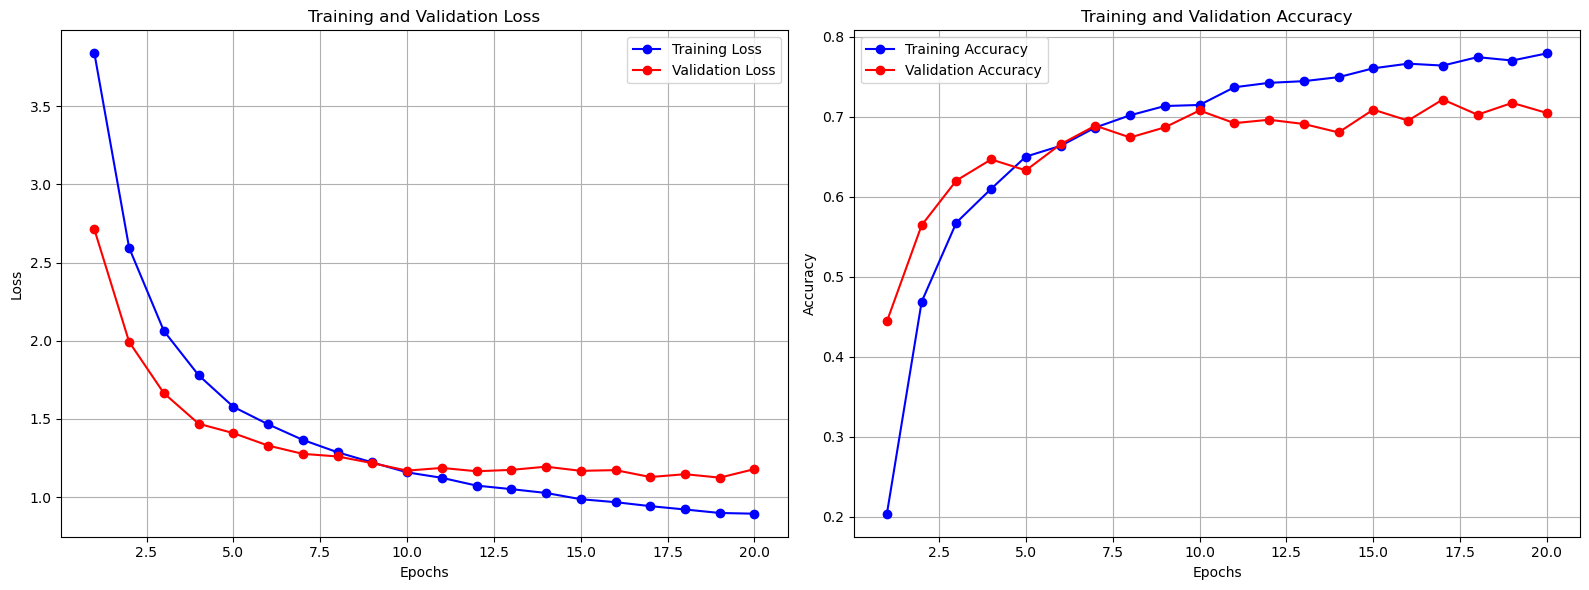

In [17]:
epochs = range(1, len(history_train_loss) + 1)

plt.figure(figsize=(16, 6))

# Plot 1: Training & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history_train_loss, 'b-o', label='Training Loss')
plt.plot(epochs, history_val_loss, 'r-o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, history_train_acc, 'b-o', label='Training Accuracy')
plt.plot(epochs, history_val_acc, 'r-o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [18]:
# --- 1. Load the Best Model ---
print("Loading best fine-tuned model for evaluation...")
# Create a new instance of the model architecture
eval_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg', trust_repo=True)
eval_model.head = nn.Linear(768, NUM_CLASSES)

# Load the saved weights (state_dict)
eval_model.load_state_dict(torch.load(BEST_MODEL_PATH, weights_only=True))
eval_model = eval_model.to(DEVICE)
eval_model.eval() # Set to evaluation mode
print("Best model loaded successfully.")

# --- 2. Evaluate on Test Set ---
all_predictions = []

with torch.no_grad():
    for images in tqdm(test_loader, desc="Evaluating on Test Set"):
        images = images.to(DEVICE)
        outputs = eval_model(images)
        all_predictions.append(outputs.cpu())

# Concatenate all batch outputs into one big tensor
y_pred_probas = torch.cat(all_predictions, dim=0)
print("Evaluation complete.")

Loading best fine-tuned model for evaluation...


Using cache found in /home/wongxuanyong/.cache/torch/hub/facebookresearch_dinov2_main


Best model loaded successfully.


Evaluating on Test Set: 100%|██████████| 7/7 [00:13<00:00,  1.92s/it]

Evaluation complete.


In [19]:
print("Calculating metrics for New Approach...")

# --- 1. Top-1 Accuracy ---
y_pred_top1 = torch.argmax(y_pred_probas, dim=1).numpy()
top1_acc = accuracy_score(y_test, y_pred_top1)
print(f"  Top-1 Accuracy: {top1_acc * 100:.2f}%")

# --- 2. Top-5 Accuracy ---
all_class_labels = np.arange(NUM_CLASSES)
top5_acc = top_k_accuracy_score(y_test, y_pred_probas.numpy(), k=5, labels=all_class_labels)
print(f"  Top-5 Accuracy: {top5_acc * 100:.2f}%")

Calculating metrics for New Approach...
  Top-1 Accuracy: 68.12%
  Top-5 Accuracy: 79.23%


Generating confusion matrix...


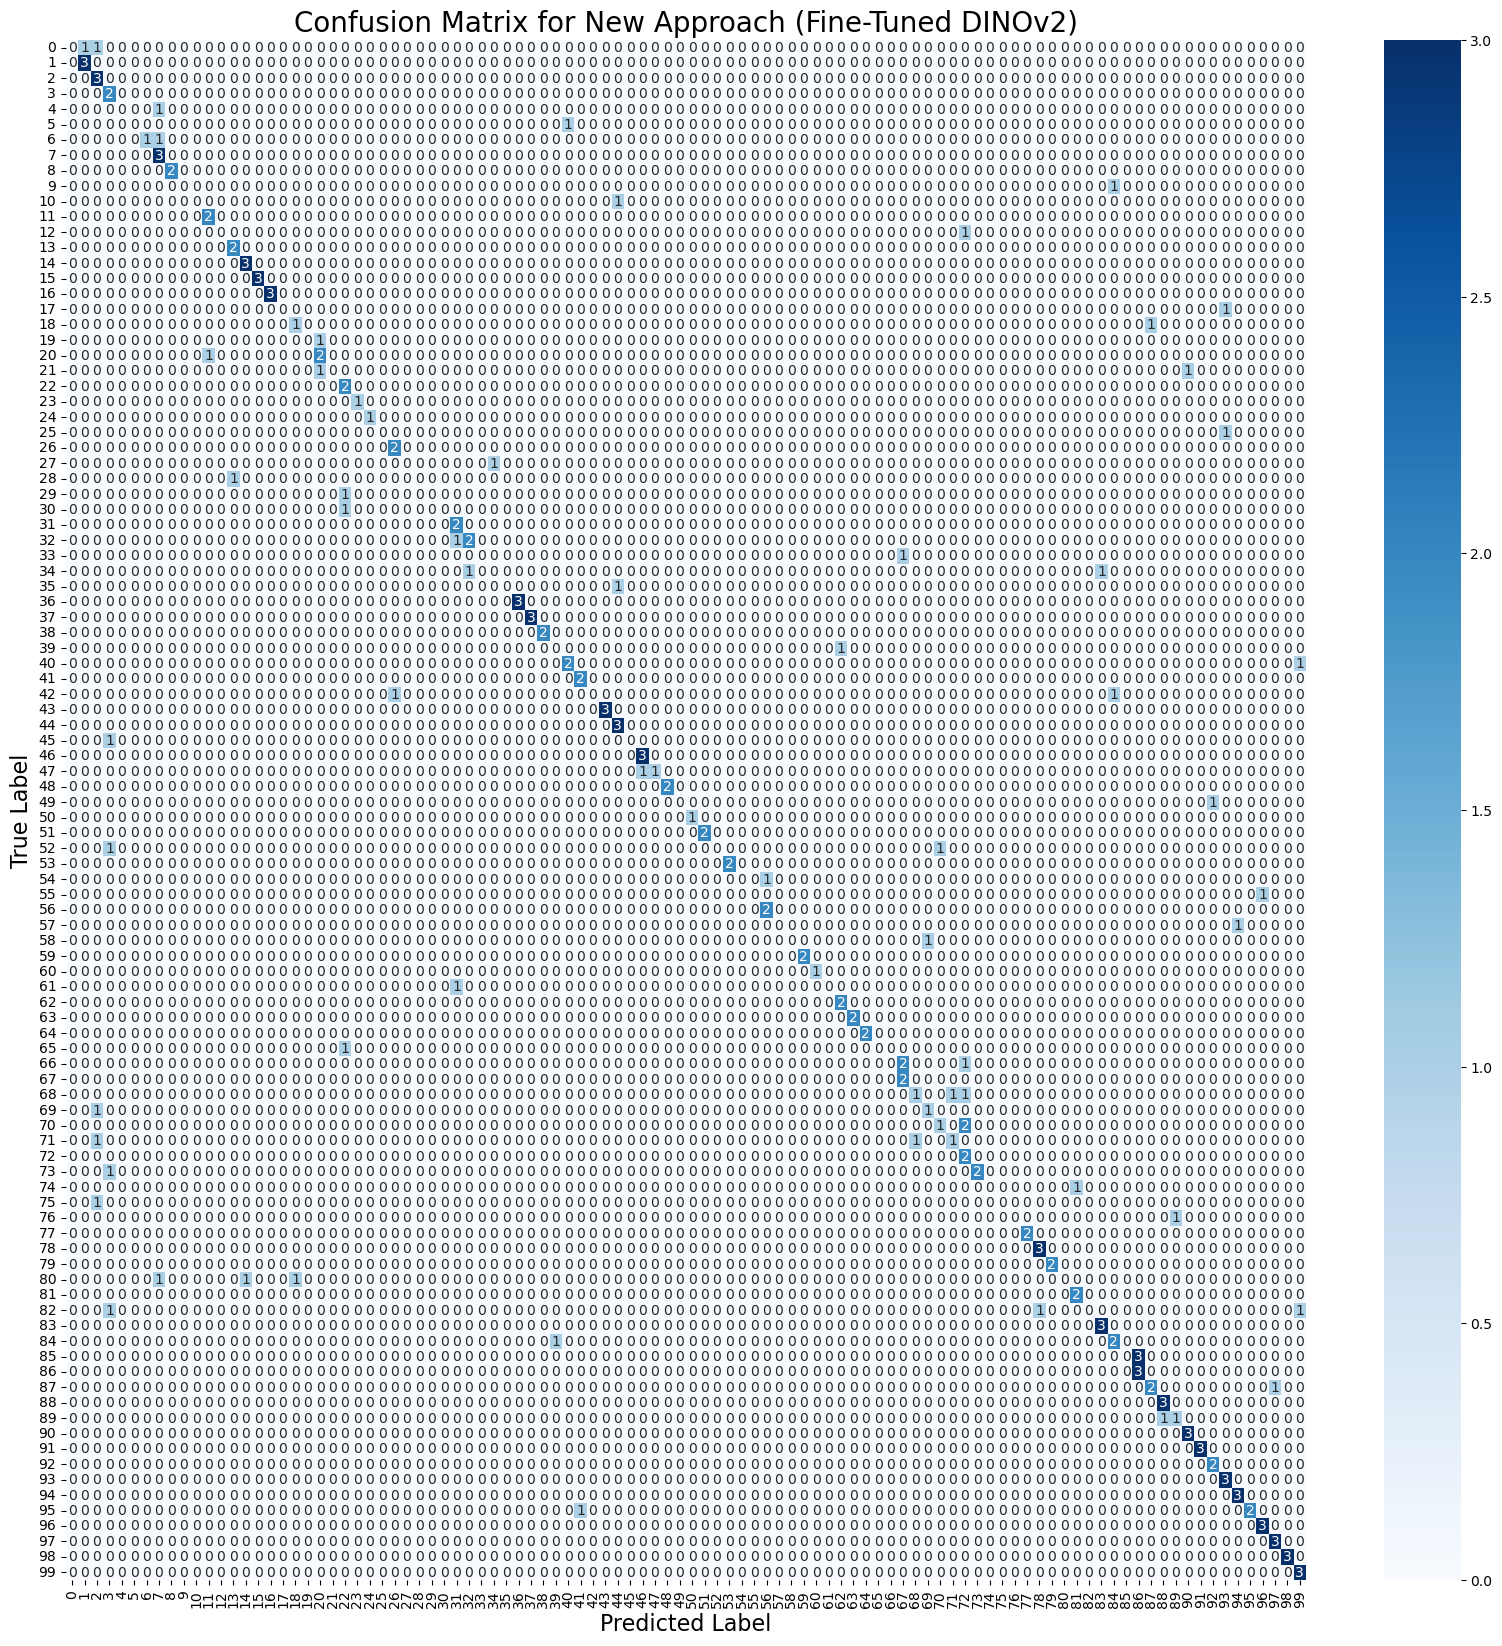

In [20]:
print("Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred_top1)

plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=all_class_labels, yticklabels=all_class_labels)
plt.title('Confusion Matrix for New Approach (Fine-Tuned DINOv2)', fontsize=20)
plt.ylabel('True Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.show()

In [ ]:
print("--- Analysis of Performance by Class Type ---")

# 1. Load original Species ID lists
with_pairs_ids = set(pd.read_csv(WITH_PAIRS_FILE, header=None).iloc[:, 0])
without_pairs_ids = set(pd.read_csv(WITHOUT_PAIRS_FILE, header=None).iloc[:, 0])

# 2. Map Species IDs to our new Class Indices (0-99)
with_pairs_set = {label_map.get(id, -1) for id in with_pairs_ids}
without_pairs_set = {label_map.get(id, -1) for id in without_pairs_ids}
print(f"Loaded and mapped 'with pairs'/'without pairs' class indices.")

# 3. Filter Test Results
test_with_pairs_indices = [i for i, label in enumerate(y_test) if label in with_pairs_set]
test_without_pairs_indices = [i for i, label in enumerate(y_test) if label in without_pairs_set]
print(f"Found {len(test_with_pairs_indices)} 'with pairs' samples and {len(test_without_pairs_indices)} 'without pairs' samples.")

# 4. Create Filtered Arrays
y_test_with_pairs = y_test[test_with_pairs_indices]
y_pred_top1_with_pairs = y_pred_top1[test_with_pairs_indices]
y_probas_with_pairs = y_pred_probas[test_with_pairs_indices]

y_test_without_pairs = y_test[test_without_pairs_indices]
y_pred_top1_without_pairs = y_pred_top1[test_without_pairs_indices]
y_probas_without_pairs = y_pred_probas[test_without_pairs_indices]

# 5. Calculate Accuracy
acc_top1_with = accuracy_score(y_test_with_pairs, y_pred_top1_with_pairs)
acc_top5_with = top_k_accuracy_score(y_test_with_pairs, y_probas_with_pairs, k=5, labels=all_class_labels)

acc_top1_without = accuracy_score(y_test_without_pairs, y_pred_top1_without_pairs)
acc_top5_without = top_k_accuracy_score(y_test_without_pairs, y_probas_without_pairs, k=5, labels=all_class_labels)

# 6. Print Comparison
print(f"\nGroup: WITH PAIRS (Trained on Herbarium + Field)")
print(f"  Top-1 Accuracy: {acc_top1_with * 100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5_with * 100:.2f}%")

print(f"\nGroup: WITHOUT PAIRS (Trained on Herbarium ONLY)")
print(f"  Top-1 Accuracy: {acc_top1_without * 100:.2f}%")
print(f"  Top-5 Accuracy: {acc_top5_without * 100:.2f}%")

--- Analysis of Performance by Class Type ---
Loaded and mapped 'with pairs'/'without pairs' class indices.
Found 153 'with pairs' samples and 54 'without pairs' samples.

Group: WITH PAIRS (Trained on Herbarium + Field)
  Top-1 Accuracy: 87.58%
  Top-5 Accuracy: 97.39%

Group: WITHOUT PAIRS (Trained on Herbarium ONLY)
  Top-1 Accuracy: 12.96%
  Top-5 Accuracy: 27.78%


/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/home/wongxuanyong/miniconda3/envs/aml_project/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1998: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y_true, input_name="y_true")
